# 전처리 가설 검증
- df_train + 추가데이터 전부 사용  
- 5개 나라에 대해서만 진행('칠레', '중국', '노르웨이', '태국', '베트남') > ctry_list 변수에 포함되어 있음

# Setting

### Library

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

### Date

In [2]:
from datetime import date, timedelta


def set_week(df, date):
    '''
    df : datetime 형식의 컬럼을 가지고 있는 dataframe
    date : df에서 datetime 형식을 가진 컬럼명
    return : date의 연도 컬럼과 주차 컬럼을 추가한 dataframe
    '''
    df[date] = pd.to_datetime(df[date])
    df[date] = df[date].dt.date
    df['year'] = df.apply(func=lambda x: x[date].isocalendar()[0], axis=1)
    df['week'] = df.apply(func=lambda x: x[date].isocalendar()[1], axis=1)
    df.drop(date, axis=1, inplace=True)
    

def check_week(df):
    '''
    df에 date가 전부 있는지 확인
    '''
    cnt = 0
    sdate = date(2015, 12, 28)   # start date
    edate = date(2019, 12, 30)   # end date
    delta = edate - sdate       # as timedelta
    mem = set()
    
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        year, week = day.isocalendar()[0], day.isocalendar()[1]
        if year * 100 + week in mem:
            continue
        mem.add(year * 100 + week)
        if df[(df['year'] == year) & (df['week'] == week)].empty:
            print((year, week), end="")
            cnt += 1
    if cnt > 0:
        print()
    print("missing", cnt, "values")    

### Model

In [3]:
cnt = 0
def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5


def train_model(train_data, target_data, model=LinearRegression()):  # baseline model : LInearRegression
    global cnt
    cnt += 1
    x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, random_state=0)

    model.fit(x_train, y_train)
    print("Model Training Complete!")

    pred_train, pred_test = model.predict(x_train), model.predict(x_test)
    
    plt.figure(figsize=(10, 8))
#     plt.scatter(pred_train, y_train, s=10)
    sns.regplot(pred_train, y_train, color='g')
    plt.xlabel("Predicted price")
    plt.ylabel("Actual price")
    plt.savefig(os.path.join(root, 'IMAGES', str(cnt) + '.png'), transparent=True)
    plt.show()

    # cvs = cross_val_score(model, x_test, y_test, cv = 5)
    # print(">> cross_val_score mean =", cvs.mean())
    print(">> RMSE train =", RMSE(y_train, pred_train))
    print(">> RMSE validation =", RMSE(y_test, pred_test))
    print(">> MAE train =", mean_absolute_error(pred_train, y_train))
    print(">> MAE validation =", mean_absolute_error(pred_test, y_test))
    print("-------------------------------------------------")
    
    return model

    
def print_importance(model, df, added_columns):
    importance = model.coef_
    fs_data = []
    for i, x in enumerate(importance):
        fs_data.append([abs(x), df.columns[i]])
    fs_data.sort(key=lambda x: x[0], reverse=True)
   
    # 추가한 컬럼의 중요도
    for i in range(len(fs_data)):
        if fs_data[i][1] in added_columns:
            print(fs_data[i][1], ":", fs_data[i][0] ,">", i, "순위")
    print("-------------------------------------------------")
    print("총", len(fs_data) , "개")
    
    return fs_data

### Data directory

In [4]:
root = os.path.join(os.getcwd(), 'DATA')

### Merging dataframes

In [5]:
from functools import reduce

def merge_df(df_list):
    return reduce(lambda  left,right: pd.merge(left,right, on=['year', 'week'], how='left'), df_list)

# Import Data

In [6]:
df_train = pd.read_csv(os.path.join(root, 'preprocessed_train_notencoded.csv'))
df_weather_code = pd.read_csv(os.path.join(root, 'raw_weather_code.csv'), header=0, index_col=0)
weather_list = [pd.read_csv(os.path.join(root, 'raw_weather_20151228_20161227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20161228_20171227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20171228_20181227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20181228_20191227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20191228_20201227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20201228_20210818.csv'), encoding='euc-kr')]
df_exchange = pd.read_csv(os.path.join(root, 'preprocessed_exchange.csv'))

- 앞선 가설 검증에서 제공데이터 및 1차 추가 데이터에 대한 최적화가 완료되었기에 해당 data를 가져온다
- 제조국 날씨의 경우 결측치 처리 과정이 필요하기 때문에 raw data를 가져온다
- 수출국 환율의 경우 raw data를 가져온다

----

# Basic Dataframe
df_train
- 주요 국가 추출

### Dropping Data
날짜 데이터 및 환율 데이터는 특정 국가에 대해서만 수집할 수 있었다  
따라서 제조국이 '칠레', '중국', '노르웨이', '태국', '베트남'인 경우,  
그리고 수출국이 '칠레', '중국', '노르웨이', '태국', '베트남', '페루'인 경우만 다룬다

In [7]:
df_train = df_train[(
                    # 제조국
                    (df_train['CTRY_1'] == "칠레") |
                    (df_train['CTRY_1'] == "중국") |
                    (df_train['CTRY_1'] == "노르웨이") |
                    (df_train['CTRY_1'] == "태국") | 
                    (df_train['CTRY_1'] == "베트남")
                    ) & (
                    # 수출국
                    (df_train['CTRY_2'] == "칠레") |
                    (df_train['CTRY_2'] == "중국") | 
                    (df_train['CTRY_2'] == "노르웨이") |
                    (df_train['CTRY_2'] == "태국") | 
                    (df_train['CTRY_2'] == "베트남") |
                    (df_train['CTRY_2'] == "페루")
                    )]

----

# Baseline Dataframe
df_train
- one hot encoding

In [8]:
df0_base = df_train.copy()

### One hot encoding

In [9]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df0_base = pd.get_dummies(df0_base, columns=one_hot)

## Train

Model Training Complete!


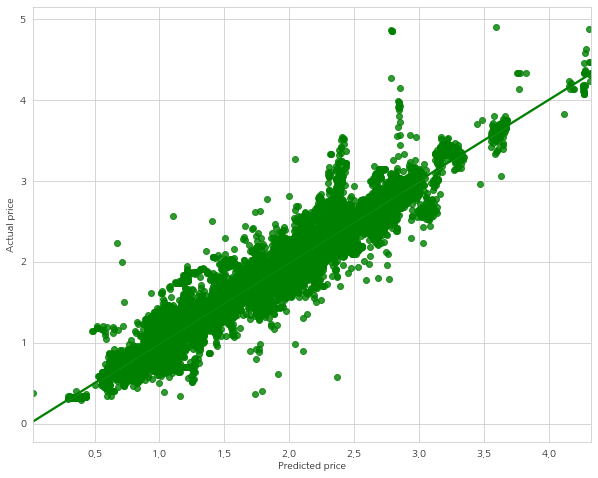

>> RMSE train = 0.20178034158408442
>> RMSE validation = 0.21534639203449177
>> MAE train = 0.13990312471904037
>> MAE validation = 0.1451043778883286
-------------------------------------------------


In [10]:
model0 = train_model(df0_base.drop(columns=['P_PRICE']), df0_base['P_PRICE'])

----
# Adding Weather Data
- df1_with_wf : 해안가여부 고려 없이 날씨 평균 데이터 추가
- df2_without_wf : 해안가인 지점 날씨 평균 데이터 추가

In [16]:
df1_with_wf = df_train.copy()
df2_without_wf = df_train.copy()

## Preprocess
- 이상치 제거 : 강수량과 풍속이 음수인 경우 제거
- '지점'에 따른 나라명 컬럼(CTRY_1)과 해안가여부(is_waterfront) 추가
- 각 나라, 일자 별로 평균 강수량, 풍속, 기온 계산

In [12]:
# 지점에 따라 나라명 추가
def set_country(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty:
        return ""
    return data.iloc[0]['국가명']


def set_waterfront(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty or data.iloc[0]['해안가여부'] != 1:
        return False
    return True
    

def preprocess_weather(df, drop_waterfront):
    df = df[(df['강수량'] >= 0) & (df['풍속'] >= 0)] # 이상치/결측치 제거
    set_week(df, '일시')  # 날짜 정보 처리
    
    # 1차 평균
    columns = ['year', 'week', '지점']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')
    
    # 나라명 추가
    df['CTRY_1'] = ""
    for i, row in df.iterrows():
        df.at[i, 'CTRY_1'] = set_country(row)
    
    # 해안가 여부 추가
    df['is_waterfront'] = False
    for i, row in df.iterrows():
        df.at[i, 'is_waterfront'] = set_waterfront(row)
     
    if drop_waterfront:
        df = df[df['is_waterfront']]  # 해안가가 아닌 데이터 제외
    
    # 2차 평균
    columns = ['year', 'week', 'CTRY_1']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')

    # 컬럼/행 정리
    df.drop(columns=['지점명', '지점', '강수량', '풍속', '기온', 'is_waterfront'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [13]:
weather_with_wf = []
weather_without_wf = []
for i in range(len(weather_list)):
    weather_with_wf.append(preprocess_weather(weather_list[i], False))
    weather_without_wf.append(preprocess_weather(weather_list[i], True))

In [14]:
df_weather_with_wf = pd.concat(weather_with_wf)
df_weather_without_wf = pd.concat(weather_without_wf)

### Check

In [19]:
print("=================해안가여부 고려X=====================")
for country in ["칠레", "중국", "노르웨이", "태국", "베트남"]:
    print(country, "총", len(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country])
    print()
    
print("=================해안가여부 고려O=====================")
for country in ["칠레", "중국", "노르웨이", "태국", "베트남"]:
    print(country, "총", len(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country])
    print()

=================해안가여부 고려X=====================
칠레 총 297 개
(2016, 5)
missing 1 values

중국 총 299 개
missing 0 values

노르웨이 총 236 개
missing 0 values

태국 총 297 개
(2016, 11)
missing 1 values

베트남 총 298 개
(2016, 6)
missing 1 values

=================해안가여부 고려O=====================
칠레 총 297 개
(2016, 5)
missing 1 values

중국 총 299 개
missing 0 values

노르웨이 총 236 개
missing 0 values

태국 총 293 개
(2016, 11)(2016, 15)(2019, 10)
missing 3 values

베트남 총 297 개
(2016, 6)
missing 1 values



### Filling Missing Values
- df_weather_with_wf : 태국, 베트남, 칠레에 결측치 1개씩
- df_weather_without_wf : 총 5개 결측치
- 결측치 > 전/차주 데이터 평균으로 채워넣기

In [21]:
def get_avg(df, year, week, country, value):
    return (df[(df['year'] == year) &
               (df['week'] == week + 1) &
               (df['CTRY_1'] == country)].iloc[0][value] 
          + df[(df['year'] == year) &
               (df['week'] == week - 1) &
               (df['CTRY_1'] == country)].iloc[0][value]) / 2

In [22]:
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 11,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_with_wf, 2016, 11, '태국', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 11, '태국', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 11, '태국', 'temperature')},
                               ignore_index=True)
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 6,
                                'CTRY_1': '베트남',
                                'rain': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'temperature')},
                               ignore_index=True)
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 5,
                                'CTRY_1': '칠레',
                                'rain': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'temperature')},
                               ignore_index=True)

for country in ["태국", "베트남", "칠레"]:
    print()
    print(country, "총", len(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country])


태국 총 298 개
missing 0 values

베트남 총 299 개
missing 0 values

칠레 총 298 개
missing 0 values


In [23]:
df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 11,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2016, 11, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 11, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 11, '태국', 'temperature')},
                               ignore_index=True)
df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 15,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2016, 15, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 15, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 15, '태국', 'temperature')},
                               ignore_index=True)
df_weather_without_wf = df_weather_without_wf.append({'year': 2019,
                                'week': 10,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2019, 10, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2019, 10, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2019, 10, '태국', 'temperature')},
                               ignore_index=True)

df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 6,
                                'CTRY_1': '베트남',
                                'rain': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'temperature')},
                               ignore_index=True)

df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 5,
                                'CTRY_1': '칠레',
                                'rain': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'temperature')},
                               ignore_index=True)

for country in ["태국", "베트남", "칠레"]:
    print()
    print(country, "총", len(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country])


태국 총 296 개
missing 0 values

베트남 총 298 개
missing 0 values

칠레 총 298 개
missing 0 values


### Merge Data

In [24]:
df1_with_wf = pd.merge(df1_with_wf, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [25]:
df2_without_wf = pd.merge(df2_without_wf, df_weather_without_wf, how='left', on=['year', 'week', 'CTRY_1'])

### One hot encoding

In [26]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df1_with_wf = pd.get_dummies(df1_with_wf, columns=one_hot)
df2_without_wf = pd.get_dummies(df2_without_wf, columns=one_hot)

## Train

Model Training Complete!


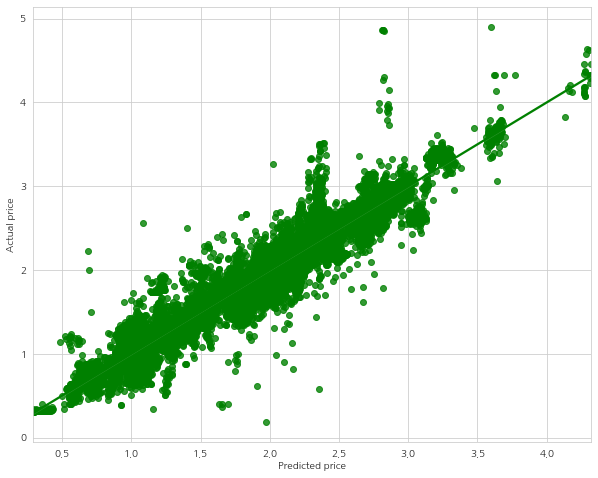

>> RMSE train = 0.20329161376553467
>> RMSE validation = 0.20860845445673648
>> MAE train = 0.1396896152581448
>> MAE validation = 0.14300160969250514
-------------------------------------------------


In [27]:
model1 = train_model(df1_with_wf.drop(columns=['P_PRICE']), df1_with_wf['P_PRICE'])

In [28]:
t1 = print_importance(model1, df1_with_wf, ['rain', 'wind', 'temperature'])

temperature : 0.03886716431413162 > 257 순위
rain : 0.0009992099166685198 > 281 순위
wind : 8.004264947120143e-05 > 286 순위
-------------------------------------------------
총 317 개


Model Training Complete!


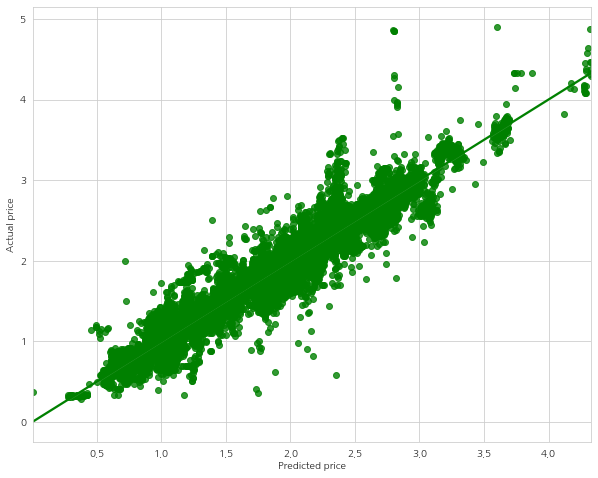

>> RMSE train = 0.1998230670247233
>> RMSE validation = 0.21798724240719716
>> MAE train = 0.13877631314989514
>> MAE validation = 0.1460983458271968
-------------------------------------------------


In [29]:
model2 = train_model(df2_without_wf.drop(columns=['P_PRICE']), df2_without_wf['P_PRICE'])

In [30]:
t2 = print_importance(model2, df2_without_wf, ['rain', 'wind', 'temperature'])

temperature : 0.09606703174956388 > 214 순위
rain : 0.0002130546342242745 > 285 순위
wind : 8.231910414108201e-05 > 287 순위
-------------------------------------------------
총 317 개


- 날씨 데이터를 추가하는 것이 모델 정확도 상승에 영향을 준다
- 해안가가 아닌 데이터를 제거하는 것은 오히려 정확도를 떨어뜨린다
- 날씨 데이터를 전부 사용한다

----
# Adding Exchange Data
- df3_add_exchange : 수출국의 환율 데이터 추가

In [31]:
df3_add_exchange = df_train.copy()

## Preprocess
### Merge Data

In [33]:
df3_add_exchange = pd.merge(df3_add_exchange, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [34]:
df3_add_exchange = pd.merge(df3_add_exchange, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

### One hot encoding

In [35]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df3_add_exchange = pd.get_dummies(df3_add_exchange, columns=one_hot)

## Train

Model Training Complete!


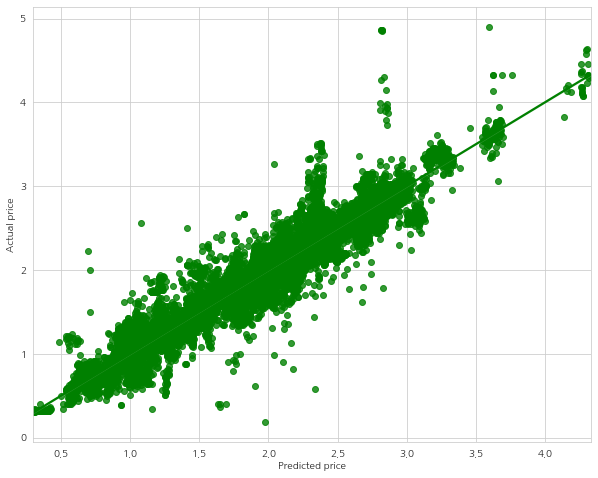

>> RMSE train = 0.20315668299863276
>> RMSE validation = 0.20859677892369408
>> MAE train = 0.1396331005394069
>> MAE validation = 0.1428509706541048
-------------------------------------------------


In [36]:
model3 = train_model(df3_add_exchange.drop(columns=['P_PRICE']), df3_add_exchange['P_PRICE'])

In [37]:
t3 = print_importance(model3, df3_add_exchange, ['exchange'])

exchange : 0.03577336157071874 > 260 순위
-------------------------------------------------
총 318 개


- 미세하게 모델 정확도가 상승하였으므로 환율 데이터도 사용하도록 한다

----
# Standardization

In [50]:
df4_transform = df_train.copy()

## Preprocess
### Merge Data

In [51]:
df4_transform = pd.merge(df4_transform, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [52]:
df4_transform = pd.merge(df4_transform, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

### Stanardization
- 추가한 Numerical Feauture : wind, rain, temperature, exchange
- 이에 대해 분포를 확인한 후, 정규화를 진행한다

#### wind

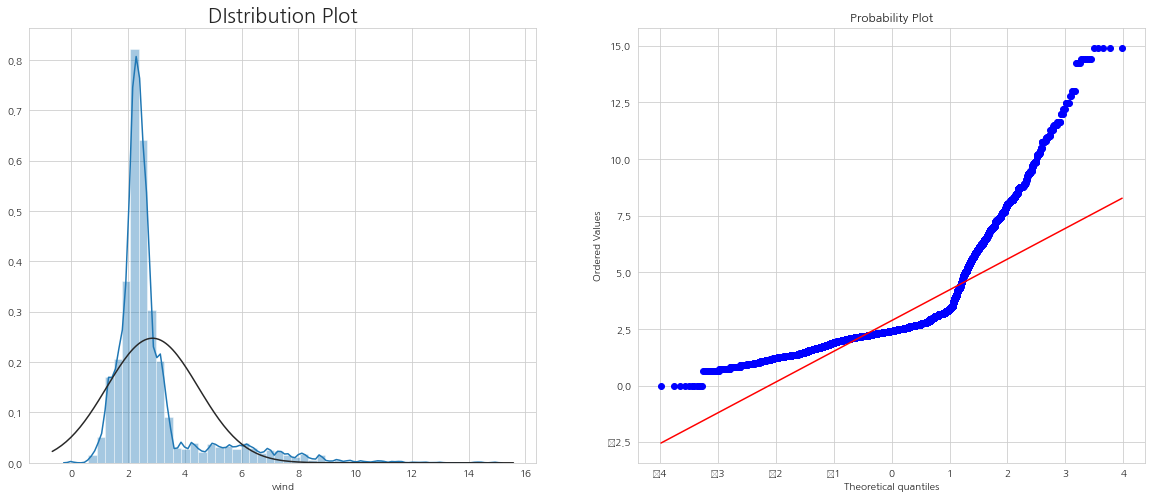

In [53]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['wind'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [54]:
# Log Transformation
df4_transform['wind'] = np.log1p(df4_transform['wind'])

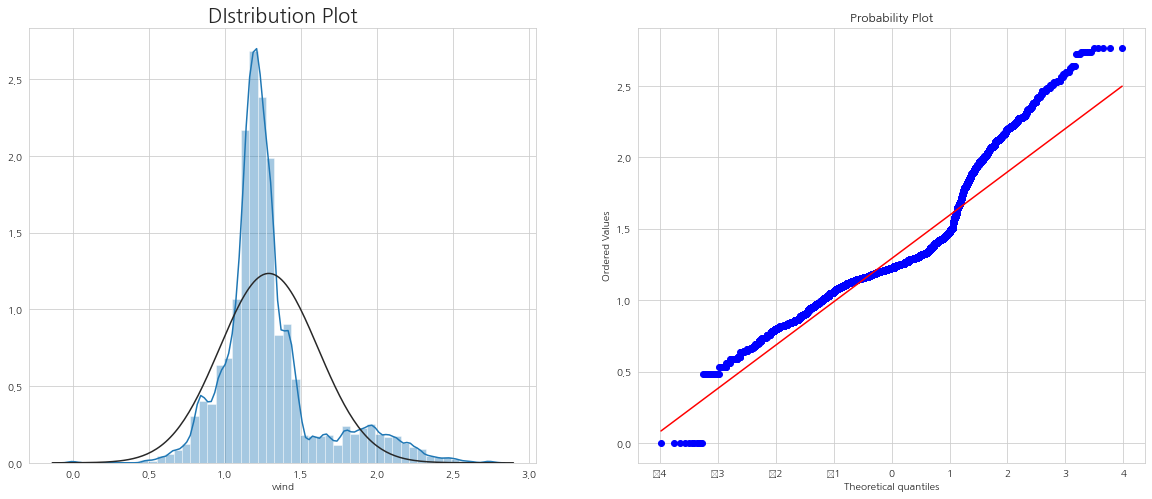

In [55]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['wind'], plot=plt)

plt.show()

#### rain

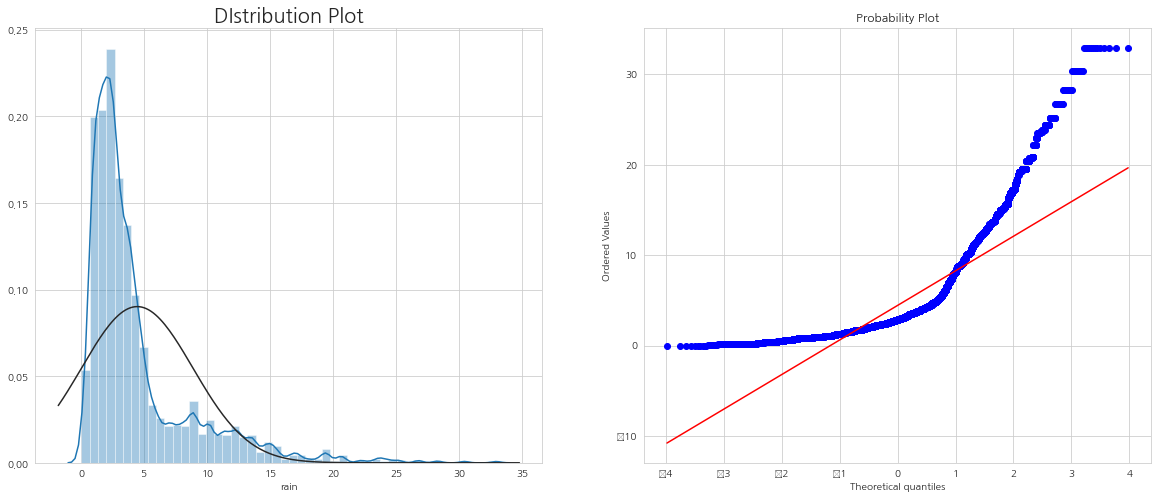

In [56]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['rain'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [57]:
# Log Transformation
df4_transform['rain'] = np.log1p(df4_transform['rain'])

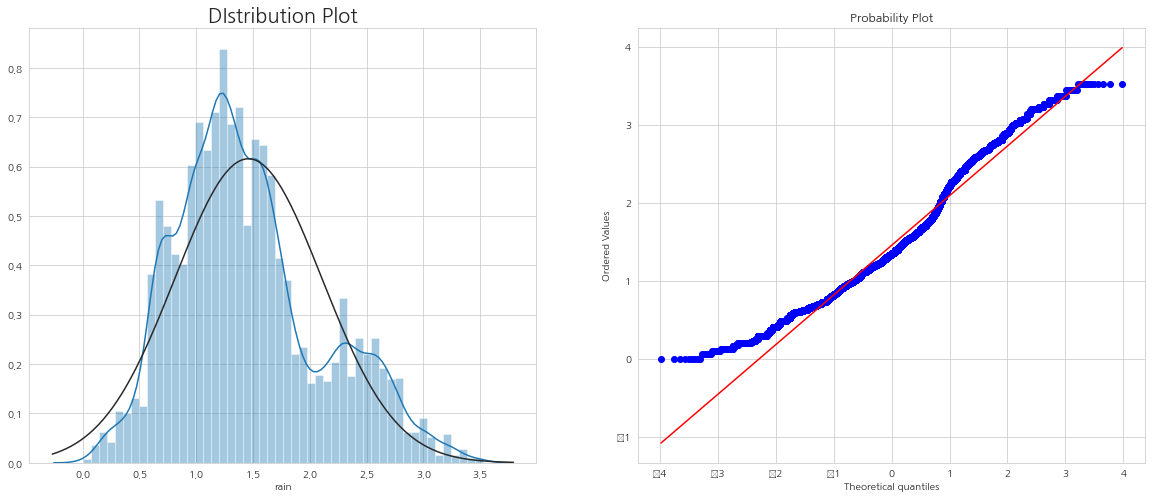

In [58]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['rain'], plot=plt)

plt.show()

#### temperature

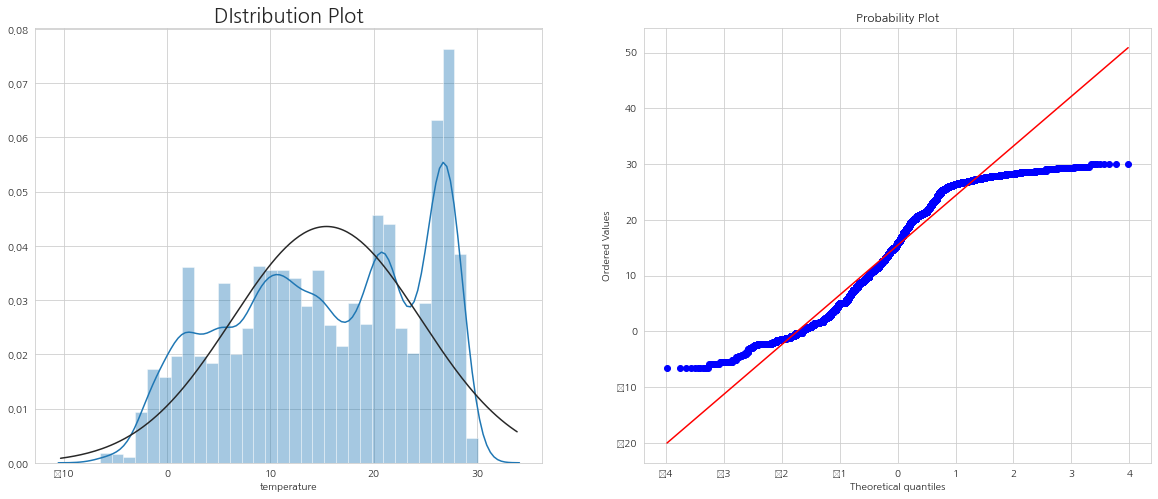

In [59]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['temperature'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [60]:
# Log Transformation
df4_transform['temperature'] = np.log1p(df4_transform['temperature'])

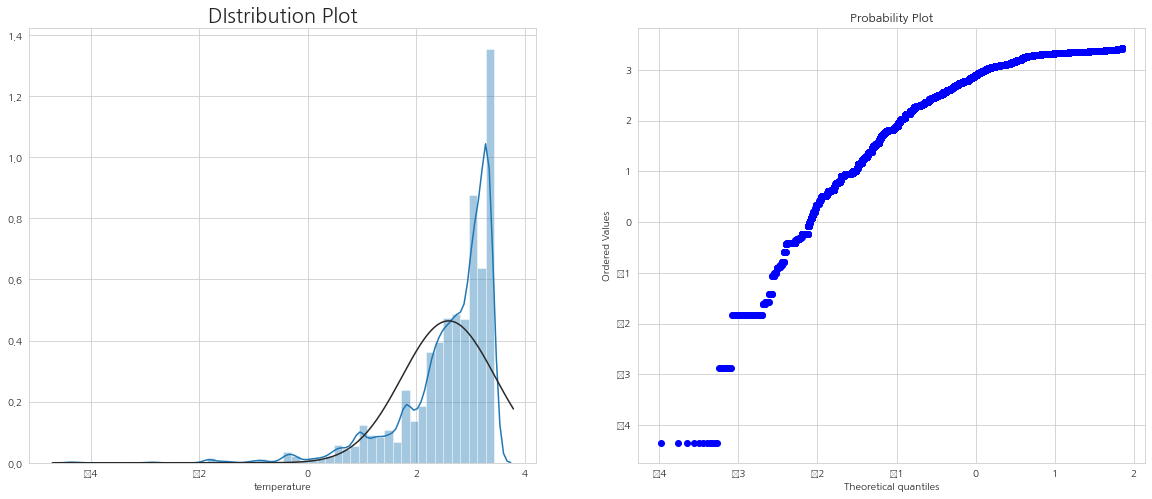

In [61]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['temperature'], plot=plt)

plt.show()

#### exchange

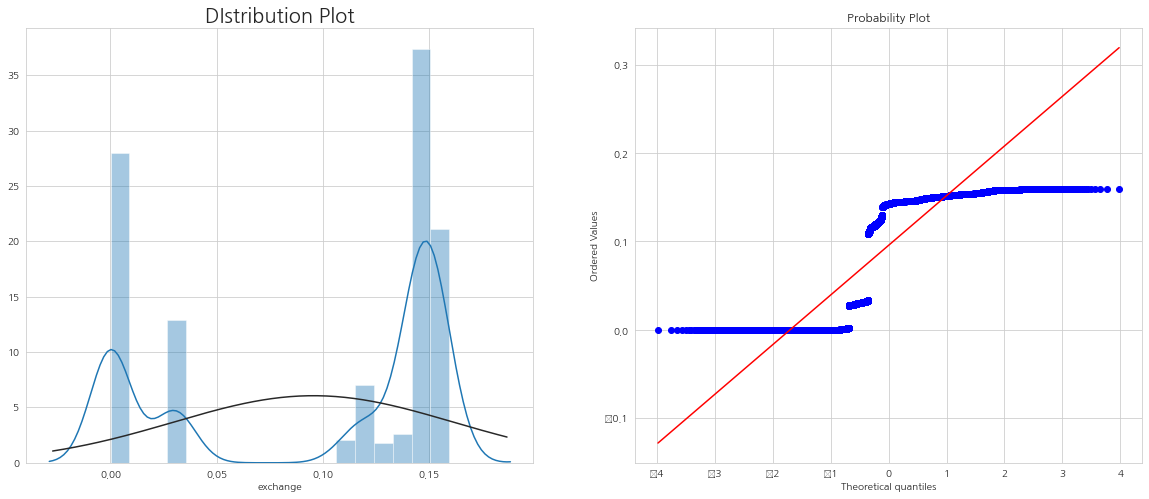

In [62]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['exchange'], plot=plt)

plt.show()

### Scaling

### One hot encoding

In [65]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df4_transform = pd.get_dummies(df4_transform, columns=one_hot)

## Train

In [66]:
model4 = train_model(df4_transform.drop(columns=['P_PRICE']), df4_transform['P_PRICE'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [37]:
t4 = print_importance(model4, df4_transform, [])

exchange : 0.03577336157071874 > 260 순위
-------------------------------------------------
총 318 개


# df9_add

In [ ]:
df9_add = df8_add.copy()

In [ ]:
columns = ['wind_kr','temperature_kr','water_temp_kr','oil','cpi_total','cpi_fish','exchange']

In [ ]:
for i in columns:

  if i == 'wind_kr':
    f, ax = plt.subplots(figsize = (15, 5)) 
    plt.subplot(151)
    sns.distplot(df9_add[i])
    
    df_copy = df9_add.copy()
    df_copy[columns] = np.log1p(df_copy[columns])
    plt.subplot(152)
    sns.distplot(df_copy[i])

    df_copy1 = df9_add.copy()
    scaler = StandardScaler()
    df_copy1[columns] = scaler.fit_transform(df_copy1[columns])
    plt.subplot(153)
    sns.distplot(df_copy1[i])
    
    df_copy2 = df9_add.copy()
    scaler = RobustScaler()
    df_copy2[columns] = scaler.fit_transform(df_copy2[columns])
    plt.subplot(154)
    sns.distplot(df_copy2[i])
    
    df_copy3 = df9_add.copy()
    scaler = MinMaxScaler()
    df_copy3[columns] = scaler.fit_transform(df_copy3[columns])
    plt.subplot(155)
    sns.distplot(df_copy3[i])

In [ ]:
from scipy import stats 

fig = plt.figure(figsize = (15,10))

for i in columns:

  if i == 'water_temp_kr':
    fig.add_subplot(151) 
    res = stats.probplot(df9_add[i], plot=plt) 
    
    fig.add_subplot(152) 
    res = stats.probplot(df_copy[i], plot=plt)
    
    fig.add_subplot(153) 
    res = stats.probplot(df_copy1[i], plot=plt)
    
    fig.add_subplot(154) 
    res = stats.probplot(df_copy2[i], plot=plt)
    
    fig.add_subplot(155) 
    res = stats.probplot(df_copy3[i], plot=plt)

oil를 제외한 모든 추가 변수는 로그 변환

oil은 표준화

날씨 데이터는 이상치 처리 후 정규화 예정



In [ ]:
df9_add['wind_kr'] = np.log1p(df9_add['wind_kr'])
df9_add['water_temp_kr'] = np.log1p(df9_add['water_temp_kr'])
df9_add['oil'] = np.log1p(df9_add['oil'])
df9_add['cpi_total'] = np.log1p(df9_add['cpi_total'])
df9_add['cpi_fish'] = np.log1p(df9_add['cpi_fish'])
df9_add['exchange'] = np.log1p(df9_add['exchange'])

df9_add['temperature_kr'] = (df9_add['temperature_kr'] - df9_add['temperature_kr'].mean())/df9_add['temperature_kr'].std()
df9_add['oil'] = (df9_add['oil'] - df9_add['oil'].mean())/df9_add['oil'].std()

df9_add


# df10_fillna 

In [ ]:
df10_fillna = df9_add.copy()

df10_fillna = df10_fillna.sort_values('CTRY_1')

df10_fillna.isna().sum()

페루 날씨 데이터만 결측치 존재 -> 가까운 페루 데이터로 대치

In [ ]:
df10_fillna.fillna(method='ffill',inplace=True)

df10_fillna.isna().sum()

In [ ]:
df10_fillna

## Encoding

In [ ]:
df10_fillna_encoding = pd.get_dummies(df10_fillna,columns=['CTRY_1','CTRY_2','CATEGORY_1','P_PURPOSE','P_NAME'])

df10_fillna_encoding

## result

In [ ]:
x_features = df10_fillna_encoding.iloc[:,1:]
y_target = df10_fillna_encoding['P_PRICE']

train_model(x_features,y_target)

# 추가 데이터 스케일링, 결측치 처리 완료 모델

# df11_outlier

In [ ]:
df12_outlier = df10_fillna.copy()

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(231)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='노르웨이']['temperature'])

plt.subplot(232)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='중국']['temperature'])

plt.subplot(233)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='칠레']['temperature'])

plt.subplot(234)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='페루']['temperature'])

plt.subplot(235)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='베트남']['temperature'])

plt.subplot(236)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='태국']['temperature'])

plt.show()

# 각 나라 최저,최고기온 비교 후 이상치 여부 판단
# 이상치 존재 x

In [ ]:
df12_outlier['temperature'] = (df12_outlier['temperature'] - df12_outlier['temperature'].mean())/df12_outlier['temperature'].std()
df12_outlier['rain'] = (df12_outlier['rain'] - df12_outlier['rain'].mean())/df12_outlier['rain'].std()
df12_outlier['wind'] = (df12_outlier['wind'] - df12_outlier['wind'].mean())/df12_outlier['wind'].std()

## Encoding

In [ ]:
df12_outlier_encoding = pd.get_dummies(df12_outlier,columns=['CTRY_1','CTRY_2','CATEGORY_1','P_PURPOSE','P_NAME'])

df12_outlier_encoding

## Result

In [ ]:
x_features = df12_outlier_encoding.iloc[:,1:]
y_target = df12_outlier_encoding['P_PRICE']

train_model(x_features,y_target)

# 날씨 데이터 스케일링 완료 모델

# Final

위 결과들을 토대로 최종 결과 도출.

## Preprocessing

In [ ]:
# df1_date
# df6_category

df_add = pd.merge(df0_base[['P_PRICE','year','week','CTRY_1','CTRY_2','CATEGORY_1','CATEGORY_2','P_PURPOSE','P_NAME']],df_oil,on=['year','week'])
df_add = pd.merge(df_add,df_weather,on=['year','week','CTRY_1'])
df_add = pd.merge(df_add,df_weather_kr,on=['year','week'])
df_add = pd.merge(df_add,df_exchange,on=['year','week','CTRY_2'])
df_add = pd.merge(df_add,df_cpi,on=['year','week'])

df_add

In [ ]:
# df4_name
# 어종별 수 컬럼 추가

df_add['name_cnt'] = 0;
value_dict = {}
for name, value in zip(df_add['P_NAME'].value_counts().index,df_add['P_NAME'].value_counts()):
    value_dict[name] = value

def value(col):
    return value_dict[col]

df_add['name_cnt'] = df_add['P_NAME'].apply(value)

In [ ]:
sns.displot(df_add['P_PRICE']) # 왜도가 매우 심함 -> 스케일링 필요

In [ ]:
sns.displot(np.log1p(df_add['P_PRICE'])) # 정규분포에 가까운 형태로 변환.

In [ ]:
# df9_add

df_add['P_PRICE'] = np.log1p(df_add['P_PRICE'])
df_add['wind_kr'] = np.log1p(df_add['wind_kr'])
df_add['water_temp_kr'] = np.log1p(df_add['water_temp_kr'])
df_add['oil'] = np.log1p(df_add['oil'])
df_add['cpi_total'] = np.log1p(df_add['cpi_total'])
df_add['cpi_fish'] = np.log1p(df_add['cpi_fish'])
df_add['exchange'] = np.log1p(df_add['exchange'])

df_add['temperature_kr'] = (df_add['temperature_kr'] - df_add['temperature_kr'].mean())/df_add['temperature_kr'].std()
df_add['oil'] = (df_add['oil'] - df_add['oil'].mean())/df_add['oil'].std()
df_add['rain'] = (df_add['rain'] - df_add['rain'].mean())/df_add['rain'].std()
df_add['wind'] = (df_add['wind'] - df_add['wind'].mean())/df_add['wind'].std()
df_add['temperature'] = (df_add['temperature'] - df_add['temperature'].mean())/df_add['temperature'].std()


df_add


## Encoding

In [ ]:
# Categorical Features Encoding

df_add_encoding = pd.get_dummies(df_add,columns=['CTRY_1','CTRY_2','CATEGORY_1','CATEGORY_2','P_PURPOSE','P_NAME'])

df_add_encoding

## Result

In [ ]:
x_features = df_add_encoding.iloc[:,1:]
y_target = df_add_encoding['P_PRICE']

train_model(x_features,y_target)

## Feature Selection

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(df_add.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

cpi_fish, cpi_total은 다중공선성 우려, 상관관계 낮음
-> cpi_avg = (cpi_fish + cpi_total)/2 라는 새로운 파생변수 생성

temperature_kr, water_temp_kr은 다중공선성 우려, 상관관계 낮음
-> weather_kr = (temperature_kr+water_temp_kr+wind_kr)/3 라는 새로운 파생변수 생성

rain,wind,temperature 상관관계 낮음
-> weather = (temperature+rain+wind)/3 라는 새로운 파생변수 생성

oil은 타 변수들과 다중공선성 우려, 상관관계 낮음
-> 삭제

### Preprocessing

In [ ]:
df_add_selection = df_add.copy()

df_add_selection['cpi_avg'] = (df_add_selection['cpi_fish']+df_add_selection['cpi_total'])/2
df_add_selection['weather_kr'] = (df_add_selection['temperature_kr']+df_add_selection['water_temp_kr']+df_add_selection['wind_kr'])/3
df_add_selection['weather'] = (df_add_selection['temperature']+df_add_selection['rain']+df_add_selection['wind'])/3

df_add_selection.drop(['cpi_total','cpi_fish','water_temp_kr','temperature_kr','wind_kr','rain','wind','temperature','oil'],axis=1,inplace=True)

df_add_selection = df_add_selection.set_index(['year','week'])

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(df_add_selection.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
from scipy import stats 

fig = plt.figure(figsize = (15,10))

for i in columns:

  if i == 'weather':
    fig.add_subplot(151) 
    res = stats.probplot(df_add_selection[i], plot=plt) 
    
    fig.add_subplot(152) 
    res = stats.probplot(df_copy[i], plot=plt)
    
    fig.add_subplot(153) 
    res = stats.probplot(df_copy1[i], plot=plt)
    
    fig.add_subplot(154) 
    res = stats.probplot(df_copy2[i], plot=plt)
    
    fig.add_subplot(155) 
    res = stats.probplot(df_copy3[i], plot=plt)

# 파생변수에 로그 변환 필요

In [ ]:
# df9_add

df_add_selection['P_PRICE'] = np.log1p(df_add_selection['P_PRICE'])
df_add_selection['weather_kr'] = np.log1p(df_add_selection['weather_kr'])
df_add_selection['cpi_avg'] = np.log1p(df_add_selection['cpi_avg'])
df_add_selection['exchange'] = np.log1p(df_add_selection['exchange'])

df_add_selection


### Encoding

In [ ]:
# Categorical Features Encoding

df_add_selection_encoding = pd.get_dummies(df_add_selection,columns=['CTRY_1','CTRY_2','CATEGORY_1','CATEGORY_2','P_PURPOSE','P_NAME'])

df_add_selection_encoding

## Final Model (Linear Regression)

In [ ]:
final_model = df_add_selection_encoding

x_features = final_model.iloc[:,1:]
y_target = final_model['P_PRICE']

train_model(x_features,y_target)